# 4章 ニューラルネットワークの学習
- 「学習」：訓練データから最適な重みパラメータの値を自動で獲得すること
- そのために損失関数という指標を導入
- この損失関数を基準として，その値が最も小さくなる重みパラメータを探し出すことが学習の目的
- パラメータの探し方である勾配法について説明する

## 4.1 データから学習する
- 今までのパーセプトロンの例ではパラメータの個数は3個程度だった
- これくらいなら手作業でなんとかできるが，数億となると難しい
- そこで自動でパラメータを決める方法について考えていく

### 4.1.1 データ駆動
- 機械学習の中心には「データ」が存在する
    - データから答えを探し
    - データからパターンを見つけ
    - データからストーリーを語る

- 図4-1 では 5 の手書き数字が多く書かれている．
- この 5 を認識するプロセスを人が見つけることは困難
- そこで SIFT や SURF，HOG といった画像に関する汎用的な特徴量と SVM などの識別器を組み合わせる方法が考えられた
- しかし，これではまだ人間の考えた特徴量をもとにしか判断ができない
- ニューラルネットワークでは，この特徴量そのものも「機械」が学習する

### 4.1.2 訓練データとテストデータ

- 訓練データとテストデータの2つに分けて，学習や実験を行うのが一般的
- 未知のデータに対する性能である「汎化性能」を測りたい
    - 「特定の人の書いた特定の文字」を認識できるようになっても，あまり嬉しくない
    - 「任意の人の書いた任意の文字」を認識できれば多くの応用が考えられる
- そのため，訓練データのみでモデルを学習し，テストデータでモデルを評価する
- あるデータセットだけに過度に対応した状態を過学習という
    - これを避けることが機械学習の重要な課題

## 4.2 損失関数

- ニューラルネットワークでは損失関数 (loss function) という一つの指標だけを手がかりにパラメータを求める
- 損失関数にはどんな関数を用いても良いが，2乗和誤差や交差エントロピー誤差などが用いられる

### 4.2.1 2乗和誤差

mean squared error

$$
    E = \frac{1}{2} \sum_{k} \left(y_k - t_k\right)^2
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y - t) ** 2)

In [3]:
t = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [4]:
y = np.array([0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0])

In [5]:
mean_squared_error(y=y, t=t)

0.09750000000000003

In [6]:
y = np.array([0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0])

In [7]:
mean_squared_error(y=y, t=t)

0.5975

#### お遊び

In [8]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y - t) ** 2, axis=1)

In [9]:
y = np.concatenate((np.zeros([101, 1]), np.linspace(0, 1, 101).reshape(-1, 1)), axis=1)

In [10]:
y.shape

(101, 2)

In [11]:
t = np.tile(np.array([[0, 1]]), (101, 1))

In [12]:
t.shape

(101, 2)

正解 t はこれ

In [13]:
t[:5]

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

こんな風に y の値を変えていくと

In [14]:
y[:5]

array([[0.  , 0.  ],
       [0.  , 0.01],
       [0.  , 0.02],
       [0.  , 0.03],
       [0.  , 0.04]])

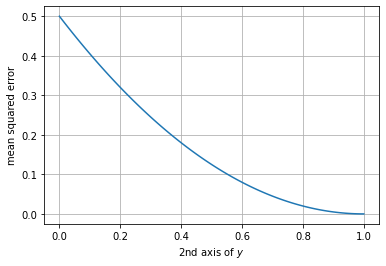

In [15]:
fig, ax = plt.subplots(1, 1)
ax.plot(y[:, 1], mean_squared_error(y, t))
ax.grid()
ax.set_xlabel('2nd axis of $y$')
ax.set_ylabel('mean squared error')
plt.show()

- t で 2次関数の位置を動かしているだけ ということがグラフからも分かる
- 実際にはこれがメッチャ多次元になる
- 久しぶりにグラフ描いた...
- 縦横のスケールをサッと揃える良い方法がないか，いつも困る

### 4.2.2 交差エントロピー誤差

cross entropy error

$$
    E = - \sum_{k} t_k \log_{e} y_k
$$

- 訓練データのラベル $t_{k}$
- 訓練データに対する推定値 $y_{k}$

$k$ はone-hot ベクトルのインデックス

In [16]:
def cross_entropy_error(y, t):
    eps = 1e-7
    return -np.sum(t * np.log(y + eps), axis=1)

#### お遊び

先ほどと同じ y, t で試してみる

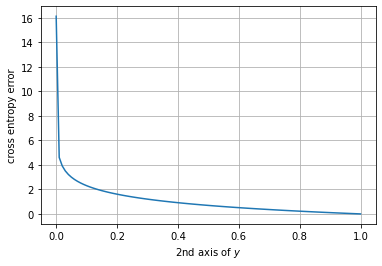

In [17]:
fig, ax = plt.subplots(1, 1)
ax.plot(y[:, 1], cross_entropy_error(y, t))
ax.grid()
ax.set_xlabel('2nd axis of $y$')
ax.set_ylabel('cross entropy error')
plt.show()

mean squared error とくらべて，$\left[0, 1\right]$ の範囲では離れた値に対してとても厳しい指標であることがわかる

次に推定値 y を少し変えてみる

In [18]:
# t が 0 に対応する y の値を変えてみる
y_modified = y.copy()
y_modified[:, 0] = 0.5

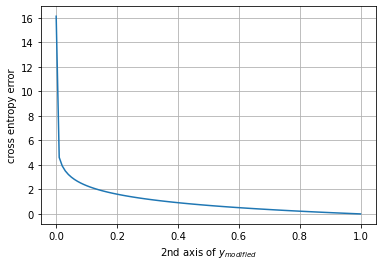

In [19]:
fig, ax = plt.subplots(1, 1)
ax.plot(y_modified[:, 1], cross_entropy_error(y_modified, t))
ax.grid()
ax.set_xlabel('2nd axis of $y_{modified}$')
ax.set_ylabel('cross entropy error')
plt.show()

同じ結果となるため，式の言う通り，正解データが 1 である場所に対応する y の値のみに依存することがわかる

- softmax 関数と，この cross entropy error の組み合わせがよく使わるらしい
- この2つの関数の合成関数を微分すると，非常にシンプルな式が出てきて実装がとても楽

### 4.2.3 ミニバッチ学習

- 学習データが多いと，まとめて誤差関数を計算することが難しくなる
- そこで小分けに誤差関数を計算して，後で辻褄を合わせることを考える
- ここでは mnist の 60,000枚 の画像から，10枚の画像（ミニバッチ）を取り出す

訓練データすべての損失関数の和は

$$
    E = - \frac{1}{N} \sum_{n} \sum_{k} t_{nk} \log_{e} y_{nk}
$$

- 訓練データの one-hot ベクトル $t_{nk}$
- 訓練データに対する推定値 $y_{nk}$

$n$ はデータのインデックス

$k$ はone-hot ベクトルのインデックス

In [20]:
from dataset.mnist import load_mnist

In [21]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [22]:
x_train.shape

(60000, 784)

In [23]:
t_train.shape

(60000, 10)

#### ミニバッチの取り出し ([numpy.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) を使用)

In [24]:
train_size = x_train.shape[0]

In [25]:
batch_size = 10

In [26]:
# 0, 1, ..., 600000 の中から 10サンプルをランダムサンプリング
batch_mask = np.random.choice(train_size, batch_size)

In [27]:
batch_mask

array([38769, 11195, 51235,  8144, 23282, 16827, 21242,  4535, 27606,
       13039])

In [28]:
x_batch = x_train[batch_mask]

In [29]:
t_batch = t_train[batch_mask]

In [30]:
x_batch

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

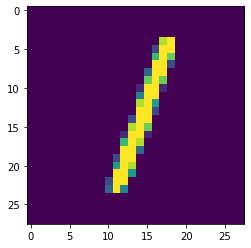

In [31]:
plt.imshow(x_batch.reshape(-1, 28, 28)[0])

In [32]:
t_batch

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [33]:
np.argmax(t_batch[0])

1

確かに 10 サンプル取得できたようです。

### 4.2.4 [バッチ対応版] 交差エントロピー誤差の実装

- 実用上はバッチに対応していることがほぼ必須要件

#### one-hot 版

In [34]:
def cross_entropy_error_one_hot(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

In [35]:
y = np.array([[0, 0.3, 0, 0.7]])

In [36]:
t = np.array([[0, 1, 0, 0]])

In [37]:
cross_entropy_error_one_hot(y, t)

1.2039724709926583

#### label 版

In [38]:
def cross_entropy_error_label(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(np.log(y[:, t] + 1e-7)) / batch_size

In [39]:
y = np.array([[0, 0.3, 0, 7]])

In [40]:
t = np.array([[1]])

In [41]:
cross_entropy_error_label(y, t)

1.2039724709926583

値の一致を確認．

- ところでこの2つって，どっちが主流なんですかね？（個人的には one-hot 版の方が違和感がない）
- あと一瞬 この損失関数って $y = \left[1, 1, 1, 1\right]$ とかになれば常に 0 になるのでは...と思ったけど，$y$ は確率なので $1 = \sum_{k} y_{k}$ っていう制約があることを忘れていました．．．
- 実際には y / np.sum(y, axis=1) をしてから渡してあげるんですかね．

### 4.2.5 なぜ損失関数を設定するのか？

- 損失関数じゃなくて，正答率を指標にすれば良くない？
- 少しの $y$ の変化でも，指標の値が変わるようにするため
    - 正答率が指標だと one-hot ベクトル $y$ の最大値が変わらない限り指標の値が変わらない
    - $y$ が変わっているのに指標の値が変わらないことがある
    - 指標の値が変わらないと，パラメータの微分がほとんどの場所で 0 になり，パラメータの更新が止まってしまう

#### お遊び

正答率 (accuracy) は変わらないけど，損失関数 (cross entropy error) は変わる例を見てみる．

In [42]:
def accuracy(y, t):
    return np.mean(np.argmax(y, axis=1) == np.argmax(t, axis=1), axis=0)

まずは適当な値で実行

In [43]:
y = np.array([[0, 0.3, 0, 0.7], [0, 0.1, 0, 0.9]])

In [44]:
t = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])

In [45]:
accuracy(y, t)

0.5

In [46]:
cross_entropy_error_one_hot(y, t)

0.6546664377696898

ここからちょっと $y$ を変えて実行

In [47]:
y += 0.1

In [48]:
y /= np.sum(y, axis=1).reshape(-1, 1)

In [49]:
y

array([[0.07142857, 0.28571429, 0.07142857, 0.57142857],
       [0.07142857, 0.14285714, 0.07142857, 0.71428571]])

In [50]:
t = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])

In [51]:
accuracy(y, t)

0.5

In [52]:
cross_entropy_error_one_hot(y, t)

0.794617357558326

正答率は変わらないが，損失関数の値だけ変わった！